# GTHA housing market database
# OSEMN methodology Step 4: Model
# Classify land use from new features in Teranet (3 classes)
# Top 11 selected features
# Model selection

Top 11 selected features and with missing past/future xy sales filled with mean future/past xy sales.

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [1]:
random_state = 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, MaxAbsScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [3]:
import sys

sys.path.append('../../../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist
from model_utils import fit_model, targets_corr, plot_learning_curve, plot_validation_curve, plot_confusion_matrix

## Load Teranet data

In [4]:
data_path = '../../../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict_3c.csv',
 'parcel16_epoi13.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 'GTAjoinedLanduseSales']

In [5]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict_3c.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 95.30 seconds
with 5,188,513 rows
and 79 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_change

## Load Census data

In [6]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'taz_level_vars',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [7]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.15 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [8]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [9]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.01 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [10]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 53.56 seconds (0.89 minutes)
with 5,188,513 rows
and 109 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=109)


## Join TTS data to Teranet data

In [11]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 48.29 seconds (0.80 minutes)
with 5,188,513 rows
and 115 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)


## Take a train-test subset of Teranet records

In [12]:
year_train_test_min = 2011
year_train_test_max = 2014
year_val1 = 2010
year_val2 = 2015

s = df.query('year >= @year_train_test_min & year <= @year_train_test_max')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1} to {2})."
      .format(len(s), year_train_test_min, year_train_test_max))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

857,896 Teranet records in the train-test subset (records from 2011 to 2014).
216,492 Teranet records in the validation subset #1 (records from 2010).
244,787 Teranet records in the validation subset #2 (records from 2015).


## Select features

In [13]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=115)

In [14]:
top11f = ['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
          'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
          'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus',
          'lucr']
s = s[top11f]
s_val1 = s_val1[top11f]
s_val2 = s_val2[top11f]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    746796 non-null float64
xy_years_to_next_sale       575944 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


## Fill missing values

In [15]:
col1 = 'xy_years_to_next_sale'
col2 = 'xy_years_since_last_sale'
mask1 = s[col1].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col1, col2, s.loc[mask1, col2].mean(), s.loc[mask1, col2].median()))
mask1 = s[col2].isnull()
print("For records with missing '{0}', values of '{1}' are: mean={2:,.2f}, median={3:,.2f}"
      .format(col2, col1, s.loc[mask1, col1].mean(), s.loc[mask1, col1].median()))

For records with missing 'xy_years_to_next_sale', values of 'xy_years_since_last_sale' are: mean=7.72, median=6.02
For records with missing 'xy_years_since_last_sale', values of 'xy_years_to_next_sale' are: mean=2.02, median=1.69


In [16]:
# missing year to next sale is replaced with median year since last sale and vice versa
mask1 = s[col1].isnull()
s.loc[mask1, col1] = s.loc[mask1, col2].median()
mask1 = s_val1[col1].isnull()
s_val1.loc[mask1, col1] = s_val1.loc[mask1, col2].median()
mask1 = s_val2[col1].isnull()
s_val2.loc[mask1, col1] = s_val2.loc[mask1, col2].median()

mask1 = s[col2].isnull()
s.loc[mask1, col2] = s.loc[mask1, col1].median()
mask1 = s_val1[col2].isnull()
s_val1.loc[mask1, col2] = s_val1.loc[mask1, col1].median()
mask1 = s_val2[col2].isnull()
s_val2.loc[mask1, col2] = s_val2.loc[mask1, col1].median()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 857896 entries, 0 to 5002104
Data columns (total 12 columns):
xy_total_sales              857896 non-null int64
xy_prev_sales               857896 non-null int64
xy_first_sale               857896 non-null bool
xy_years_since_last_sale    857896 non-null float64
xy_years_to_next_sale       857896 non-null float64
med_price_xy                857896 non-null float64
Avg_HHsize                  855523 non-null float64
Avg_rent                    855435 non-null float64
PopDens                     857896 non-null float64
DwelDens                    857896 non-null float64
Apt_5plus                   855523 non-null float64
lucr                        857896 non-null object
dtypes: bool(1), float64(8), int64(2), object(1)
memory usage: 79.4+ MB


In [17]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

855,378 rows in train-test subset, 216,155 rows in validation subset #1, 244,425 rows in validation subset #2


In [18]:
target_cols = 1
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_first_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale', 'med_price_xy',
       'Avg_HHsize', 'Avg_rent', 'PopDens', 'DwelDens', 'Apt_5plus'],
      dtype='object')

In [19]:
feat_set_name = 'top11f_3c'

## Encode target

In [20]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr'], axis=1)
s_val1 = s_val1.drop(['lucr'], axis=1)
s_val2 = s_val2.drop(['lucr'], axis=1)
print("Land use encoded!")

condo    222904
house    288879
other    343595
Name: lucr, dtype: int64
0    222904
1    288879
2    343595
Name: lucr_e, dtype: int64
condo    66944
house    77497
other    71714
Name: lucr, dtype: int64
0    66944
1    77497
2    71714
Name: lucr_e, dtype: int64
condo     57424
house     76798
other    110203
Name: lucr, dtype: int64
0     57424
1     76798
2    110203
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

### Select features and target

In [21]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


### Perform the train-test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [222904 288879 343595]
Labels counts in y_train: [156033 202215 240516]
Labels counts in y_test: [ 66871  86664 103079]
Labels counts in y_val1: [66944 77497 71714]
Labels counts in y_val2: [ 57424  76798 110203]


### Standardize features

In [23]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


### Normalize features

In [24]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


### Apply the quantile transformation (uniform pdf) to the features

In [25]:
sc = QuantileTransformer(output_distribution='uniform')
sc.fit(X_train)
X_train_qu = sc.transform(X_train)
X_test_qu = sc.transform(X_test)
X_val1_qu = sc.transform(X_val1)
X_val2_qu = sc.transform(X_val2)
print("Quantile transformation (uniform pdf) was applied to the features.")

Quantile transformation (uniform pdf) was applied to the features.


### Apply the quantile transformation (gaussian pdf) to the features

In [26]:
sc = QuantileTransformer(output_distribution='normal')
sc.fit(X_train)
X_train_qn = sc.transform(X_train)
X_test_qn = sc.transform(X_test)
X_val1_qn = sc.transform(X_val1)
X_val2_qn = sc.transform(X_val2)
print("Quantile transformation (gaussian pdf) was applied to the features.")

Quantile transformation (gaussian pdf) was applied to the features.


## Evaluate classification algorithms

In [27]:
scores_df = pd.DataFrame(columns=['train', 'test', 'val1', 'val2'])

### Linear models

#### Perceptron learning algorithm

In [28]:
n_jobs=12
eta = 0.5
max_iter = 5
model_name = "Perceptron\n(quantile transformation, uniform pdf)"
model_code = 'ppn_qu_eta{0}_maxiter{1}'.format(eta, max_iter)
ppn = Perceptron( random_state=random_state, max_iter=max_iter, eta0=eta, n_jobs=n_jobs)
scores_df.loc[model_code] = \
    fit_model(ppn, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)



Perceptron
(quantile transformation, uniform pdf) fit, took 1.43 seconds (0.02 minutes)
accuracy: train=0.75, test=0.75, validation #1=0.69, validation #2=0.74


In [29]:
ppn = Perceptron( random_state=random_state, max_iter=max_iter, eta0=eta, n_jobs=n_jobs)
ppn.fit(X_train_qu, y_train)
ppn.score(X_test_qu, y_test)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.7474183014176935

In [30]:
cr = classification_report(y_test, ppn.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Perceptron
(quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.661923,0.898268,0.685082,0.747418,0.748424,0.751044
recall,0.674029,0.854403,0.705081,0.747418,0.744504,0.747418
f1-score,0.667921,0.875787,0.694938,0.747418,0.746215,0.748974
support,66871.000000,86664.000000,103079.000000,0.747418,256614.000000,256614.000000


Perceptron
(quantile transformation, uniform pdf)
Normalized confusion matrix
[[6.74e-01 1.41e-02 3.12e-01]
 [7.50e-04 8.54e-01 1.45e-01]
 [2.23e-01 7.22e-02 7.05e-01]]


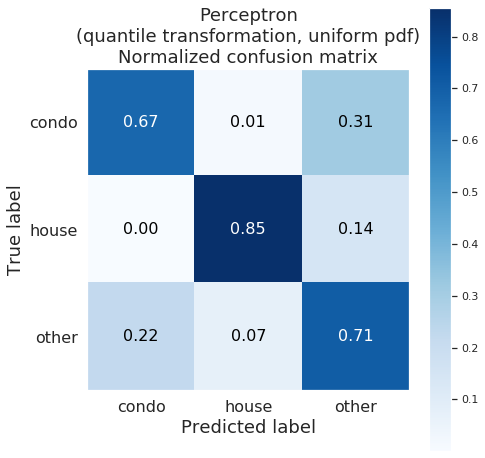

In [31]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, ppn.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

#### Logistic regression (L2 regularization)

In [32]:
n_jobs = 8
penalty = 'l2'
c = 0.1
max_iter = 100
model_name = 'Logistic regression\n({0} penalty, C={1},\nquantile transformation, uniform pdf)'.format(penalty, c)
model_code = 'lr_qu_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='lbfgs', 
                        multi_class='auto', max_iter=max_iter, n_jobs=n_jobs)
scores_df.loc[model_code] = \
    fit_model(lr, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Logistic regression
(l2 penalty, C=0.1,
quantile transformation, uniform pdf) fit, took 27.73 seconds (0.46 minutes)
accuracy: train=0.76, test=0.76, validation #1=0.71, validation #2=0.74


In [33]:
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='lbfgs', 
                        multi_class='auto', max_iter=max_iter, n_jobs=n_jobs)
lr.fit(X_train_qu, y_train)
lr.score(X_test_qu, y_test)

0.7638905125986891

In [34]:
cr = classification_report(y_test, lr.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Logistic regression
(l2 penalty, C=0.1,
quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.687893,0.880949,0.709673,0.763891,0.759505,0.761841
recall,0.654574,0.907978,0.713666,0.763891,0.758739,0.763891
f1-score,0.670820,0.894259,0.711664,0.763891,0.758914,0.762687
support,66871.000000,86664.000000,103079.000000,0.763891,256614.000000,256614.000000


Logistic regression
(l2 penalty, C=0.1,
quantile transformation, uniform pdf)
Normalized confusion matrix
[[0.65 0.01 0.33]
 [0.   0.91 0.09]
 [0.19 0.09 0.71]]


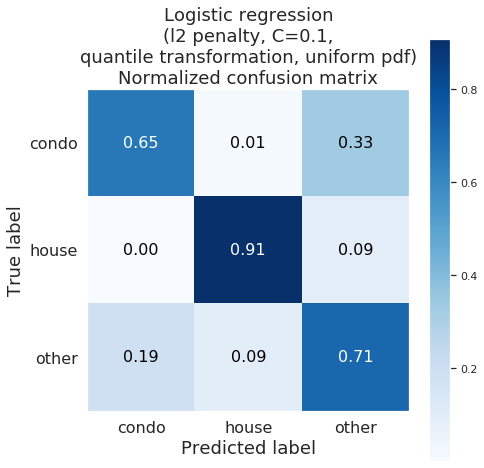

In [35]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lr.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

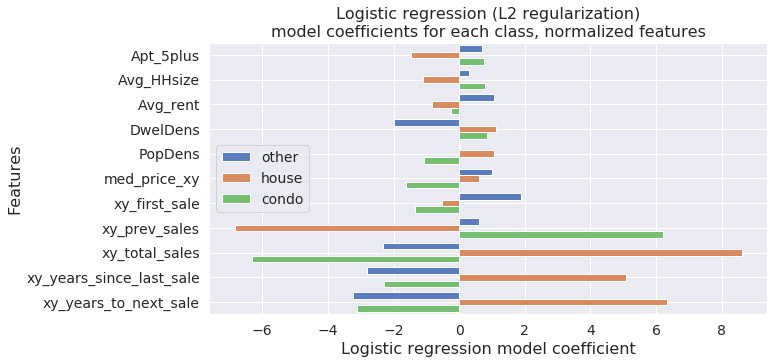

In [36]:
lr_coef = pd.DataFrame()
for cl in range(lr.coef_.shape[0]):
    class_coef = pd.DataFrame(lr.coef_[cl], index=feat_cols).reset_index()\
                   .rename(columns={'index': 'var', 0: 'coefficient'})
    class_coef['class'] = le.classes_[cl]
    lr_coef = lr_coef.append(class_coef)

f, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression (L2 regularization)\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_qu_coefs.png'
            .format(model_code, feat_set_name), dpi=300, bbox_inches='tight')

#### Logistic regression (L1 regularization)

In [37]:
penalty = 'l1'
c = 0.1
max_iter = 100
model_name = 'Logistic regression\n({0} penalty, C={1},\nquantile transformation, uniform pdf)'.format(penalty, c)
model_code = 'lr_qu_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='liblinear', 
                        multi_class='auto', max_iter=max_iter)
scores_df.loc[model_code] = \
    fit_model(lr, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf) fit, took 197.14 seconds (3.29 minutes)
accuracy: train=0.76, test=0.76, validation #1=0.71, validation #2=0.74


In [38]:
lr = LogisticRegression(random_state=random_state, penalty=penalty, C=c, solver='liblinear', 
                        multi_class='auto', max_iter=max_iter)
lr.fit(X_train_qu, y_train)
lr.score(X_test_qu, y_test)

0.7609990101865058

In [39]:
cr = classification_report(y_test, lr.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.688234,0.869832,0.709691,0.760999,0.755919,0.758182
recall,0.651388,0.910320,0.706565,0.760999,0.756091,0.760999
f1-score,0.669304,0.889616,0.708124,0.760999,0.755681,0.759302
support,66871.000000,86664.000000,103079.000000,0.760999,256614.000000,256614.000000


Logistic regression
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)
Normalized confusion matrix
[[6.51e-01 1.86e-02 3.30e-01]
 [5.54e-04 9.10e-01 8.91e-02]
 [1.91e-01 1.02e-01 7.07e-01]]


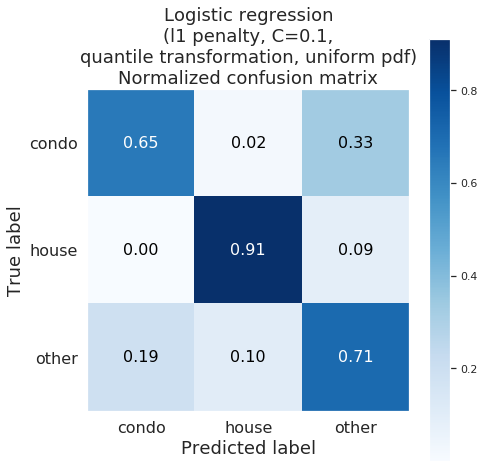

In [40]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lr.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

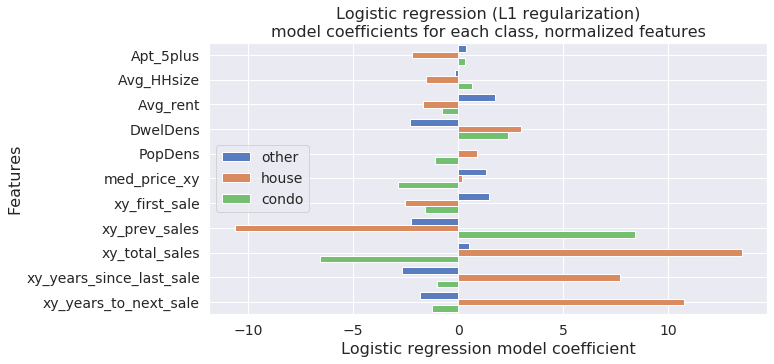

In [41]:
lr_coef = pd.DataFrame()
for cl in range(lr.coef_.shape[0]):
    class_coef = pd.DataFrame(lr.coef_[cl], index=feat_cols).reset_index()\
                   .rename(columns={'index': 'var', 0: 'coefficient'})
    class_coef['class'] = le.classes_[cl]
    lr_coef = lr_coef.append(class_coef)

f, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(x="coefficient", y="var", hue="class", data=lr_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("Logistic regression model coefficient", fontsize=16)
ax.set_title("Logistic regression (L1 regularization)\nmodel coefficients for each class, normalized features", 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_qu_coefs.png'
            .format(model_code, feat_set_name), dpi=300, bbox_inches='tight')

#### Linear Discriminant Analysis (LDA)

In [42]:
model_name = 'Linear Discriminant Analysis (LDA)'
model_code = 'lda_qu'
lda = LinearDiscriminantAnalysis()
scores_df.loc[model_code] = \
    fit_model(lda, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Linear Discriminant Analysis (LDA) fit, took 1.95 seconds (0.03 minutes)
accuracy: train=0.73, test=0.73, validation #1=0.70, validation #2=0.72


In [43]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_qu, y_train)
lda.score(X_test_qu, y_test)

0.7305213277529675

In [44]:
cr = classification_report(y_test, lda.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Linear Discriminant Analysis (LDA)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.650171,0.821430,0.697852,0.730521,0.723151,0.727162
recall,0.660137,0.891304,0.641004,0.730521,0.730815,0.730521
f1-score,0.655116,0.854942,0.668221,0.730521,0.726093,0.727865
support,66871.000000,86664.000000,103079.000000,0.730521,256614.000000,256614.000000


Linear Discriminant Analysis (LDA)
Normalized confusion matrix
[[6.60e-01 5.26e-02 2.87e-01]
 [2.42e-04 8.91e-01 1.08e-01]
 [2.30e-01 1.29e-01 6.41e-01]]


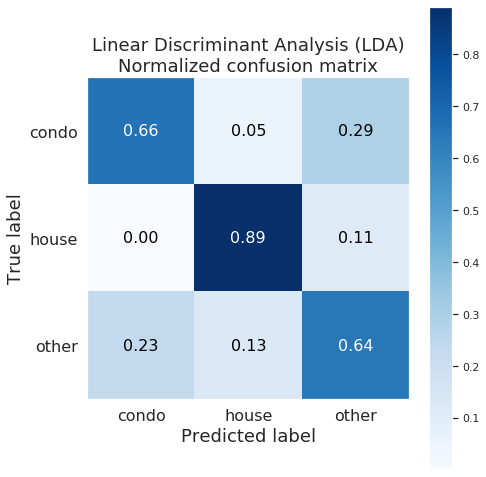

In [45]:
plot_confusion_matrix(y_test, lda.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

#### Quadratic Discriminant Analysis (QDA)

In [46]:
model_name = 'Quadratic Discriminant Analysis'
model_code = 'qda_qu'
qda = QuadraticDiscriminantAnalysis()
scores_df.loc[model_code] = \
    fit_model(qda, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Quadratic Discriminant Analysis fit, took 1.00 seconds (0.02 minutes)
accuracy: train=0.66, test=0.66, validation #1=0.67, validation #2=0.60


In [47]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_qu, y_train)
qda.score(X_test_qu, y_test)

0.6571036654274514

In [48]:
cr = classification_report(y_test, qda.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Quadratic Discriminant Analysis


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.509951,0.796246,0.790199,0.657104,0.698799,0.719211
recall,0.946449,0.953429,0.220258,0.657104,0.706712,0.657104
f1-score,0.662788,0.867777,0.344493,0.657104,0.625020,0.604162
support,66871.000000,86664.000000,103079.000000,0.657104,256614.000000,256614.000000


Quadratic Discriminant Analysis
Normalized confusion matrix
[[0.95 0.01 0.05]
 [0.01 0.95 0.03]
 [0.58 0.2  0.22]]


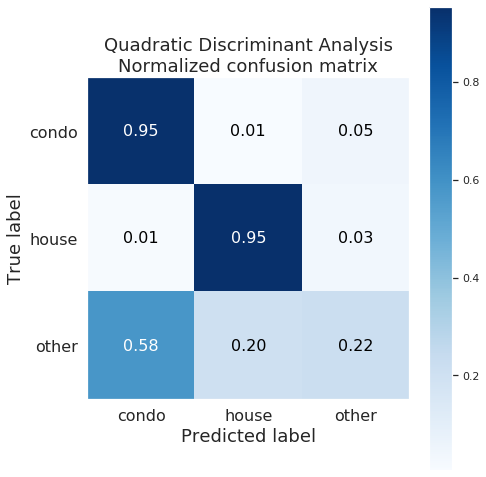

In [49]:
plot_confusion_matrix(y_test, qda.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

#### Linear Support Vector Classification (L2)

In [50]:
penalty = 'l2'
max_iter = 100
c = 0.1
model_name = 'Linear Support Vector Classification' +\
             '\n({0} penalty, C={1},\nquantile transformation, uniform pdf)'.format(penalty, c)
model_code = 'lsvc_qu_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
lsvc = LinearSVC(random_state=random_state, penalty=penalty, loss='squared_hinge', max_iter=max_iter, C=c)
scores_df.loc[model_code] = \
    fit_model(lsvc, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)


Linear Support Vector Classification
(l2 penalty, C=0.1,
quantile transformation, uniform pdf) fit, took 11.89 seconds (0.20 minutes)
accuracy: train=0.76, test=0.76, validation #1=0.71, validation #2=0.74


In [51]:
lsvc = LinearSVC(random_state=random_state, penalty=penalty, loss='squared_hinge', max_iter=max_iter, C=c)
lsvc.fit(X_train_qu, y_train)
lsvc.score(X_test_qu, y_test)

0.7590505584262744

In [52]:
cr = classification_report(y_test, lsvc.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Linear Support Vector Classification
(l2 penalty, C=0.1,
quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.687046,0.867734,0.707926,0.759051,0.754235,0.756455
recall,0.653213,0.905151,0.704877,0.759051,0.754414,0.759051
f1-score,0.669702,0.886047,0.706398,0.759051,0.754049,0.757507
support,66871.000000,86664.000000,103079.000000,0.759051,256614.000000,256614.000000


Linear Support Vector Classification
(l2 penalty, C=0.1,
quantile transformation, uniform pdf)
Normalized confusion matrix
[[6.53e-01 2.08e-02 3.26e-01]
 [4.62e-04 9.05e-01 9.44e-02]
 [1.93e-01 1.02e-01 7.05e-01]]


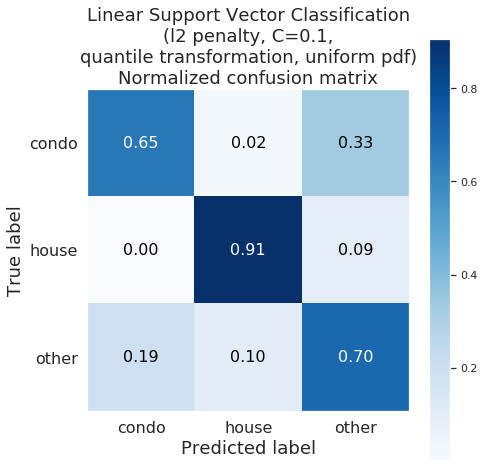

In [53]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lsvc.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

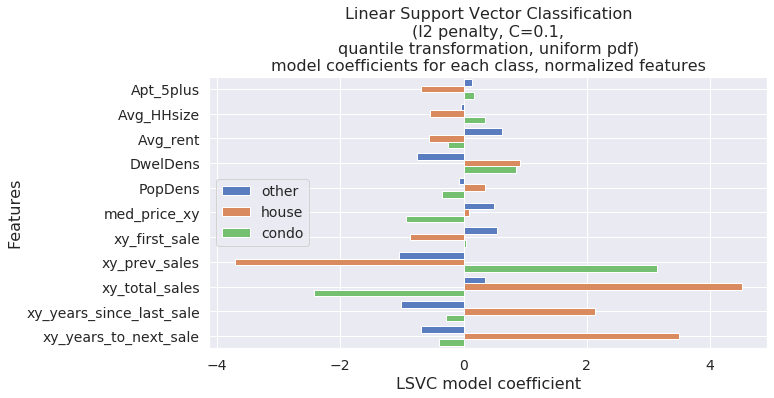

In [54]:
lsvc_coef = pd.DataFrame()
for cl in range(lsvc.coef_.shape[0]):
    class_coef = pd.DataFrame(lsvc.coef_[cl], index=feat_cols).reset_index()\
                   .rename(columns={'index': 'var', 0: 'coefficient'})
    class_coef['class'] = le.classes_[cl]
    lsvc_coef = lsvc_coef.append(class_coef)

f, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(x="coefficient", y="var", hue="class", data=lsvc_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("LSVC model coefficient", fontsize=16)
ax.set_title("{0}\nmodel coefficients for each class, normalized features".format(model_name), 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_qu_coefs.png'
            .format(feat_set_name, model_code), bbox_inches='tight')

#### Linear Support Vector Classification (L1)

In [55]:
penalty = 'l1'
max_iter = 100
c = 0.1
model_name = 'Linear Support Vector Classification' +\
             '\n({0} penalty, C={1},\nquantile transformation, uniform pdf)'.format(penalty, c)
model_code = 'lsvc_qu_{0}_c{1}_maxiter{2}'.format(penalty, c, max_iter)
lsvc = LinearSVC(random_state=random_state, penalty=penalty, loss='squared_hinge', max_iter=max_iter, C=c, dual=False)
scores_df.loc[model_code] = \
    fit_model(lsvc, model_name, X_train_qu, y_train, X_test_qu, y_test, X_val1_qu, y_val1, X_val2_qu, y_val2,
              return_scores=True)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



Linear Support Vector Classification
(l1 penalty, C=0.1,
quantile transformation, uniform pdf) fit, took 19.43 seconds (0.32 minutes)
accuracy: train=0.75, test=0.75, validation #1=0.71, validation #2=0.75


In [56]:
lsvc = LinearSVC(random_state=random_state, penalty=penalty, loss='squared_hinge', max_iter=max_iter, C=c, dual=False)
lsvc.fit(X_train_qu, y_train)
lsvc.score(X_test_qu, y_test)

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7507267725065663

In [57]:
cr = classification_report(y_test, lsvc.predict(X_test_qu), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Linear Support Vector Classification
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.686161,0.847941,0.700969,0.750727,0.745024,0.746746
recall,0.619865,0.909582,0.702063,0.750727,0.743837,0.750727
f1-score,0.651331,0.877681,0.701516,0.750727,0.743509,0.747933
support,66871.000000,86664.000000,103079.000000,0.750727,256614.000000,256614.000000


Linear Support Vector Classification
(l1 penalty, C=0.1,
quantile transformation, uniform pdf)
Normalized confusion matrix
[[6.20e-01 3.52e-02 3.45e-01]
 [3.81e-04 9.10e-01 9.00e-02]
 [1.84e-01 1.14e-01 7.02e-01]]


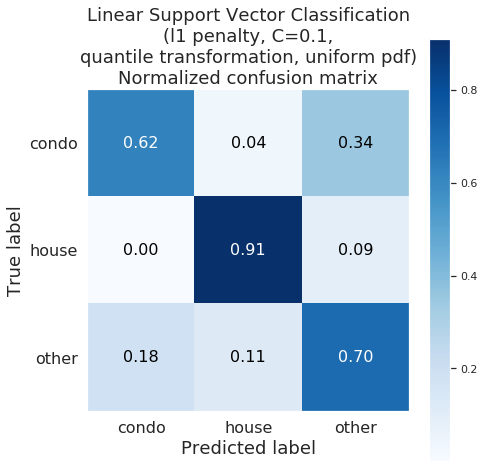

In [58]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, lsvc.predict(X_test_qu), le.classes_, model_name, normalize=True, width=7)
plt.show()

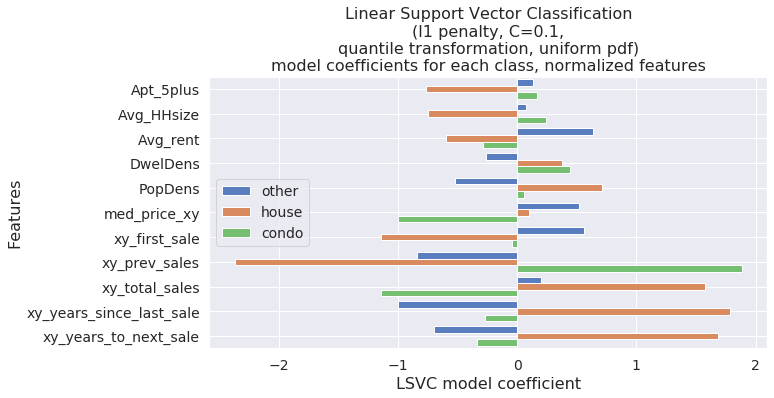

In [59]:
lsvc_coef = pd.DataFrame()
for cl in range(lsvc.coef_.shape[0]):
    class_coef = pd.DataFrame(lsvc.coef_[cl], index=feat_cols).reset_index()\
                   .rename(columns={'index': 'var', 0: 'coefficient'})
    class_coef['class'] = le.classes_[cl]
    lsvc_coef = lsvc_coef.append(class_coef)

f, ax = plt.subplots(1, figsize=(10, 5))
sns.barplot(x="coefficient", y="var", hue="class", data=lsvc_coef.sort_values('var'), palette="muted", ax=ax)
ax.set_ylabel("Features", fontsize=16)
ax.set_xlabel("LSVC model coefficient", fontsize=16)
ax.set_title("{0}\nmodel coefficients for each class, normalized features".format(model_name), 
             fontsize=16)
ax.grid(True)
ax.legend(loc='center left', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../../results/plots/{0}_{1}_feats_qu_coefs.png'
            .format(feat_set_name, model_code), bbox_inches='tight')

#### Gaussian Naive Bayes

In [60]:
model_name = "Gaussian Naive Bayes,\n(quantile transformation, gaussian pdf)"
model_code = 'nb_qn'
nb = GaussianNB()
scores_df.loc[model_code] = \
    fit_model(nb, model_name, X_train_qn, y_train, X_test_qn, y_test, X_val1_qn, y_val1, X_val2_qn, y_val2,
              return_scores=True)


Gaussian Naive Bayes,
(quantile transformation, gaussian pdf) fit, took 1.17 seconds (0.02 minutes)
accuracy: train=0.57, test=0.57, validation #1=0.62, validation #2=0.35


In [61]:
nb = GaussianNB()
nb.fit(X_train_qn, y_train)
nb.score(X_test_qn, y_test)

0.5729383431924993

In [62]:
cr = classification_report(y_test, nb.predict(X_test_qn), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Gaussian Naive Bayes,
(quantile transformation, gaussian pdf)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.473601,0.679153,0.578969,0.572938,0.577241,0.585345
recall,0.905430,0.932659,0.054803,0.572938,0.630964,0.572938
f1-score,0.621904,0.785970,0.100128,0.572938,0.502667,0.467721
support,66871.000000,86664.000000,103079.000000,0.572938,256614.000000,256614.000000


Gaussian Naive Bayes,
(quantile transformation, gaussian pdf)
Normalized confusion matrix
[[0.91 0.08 0.02]
 [0.03 0.93 0.03]
 [0.62 0.32 0.05]]


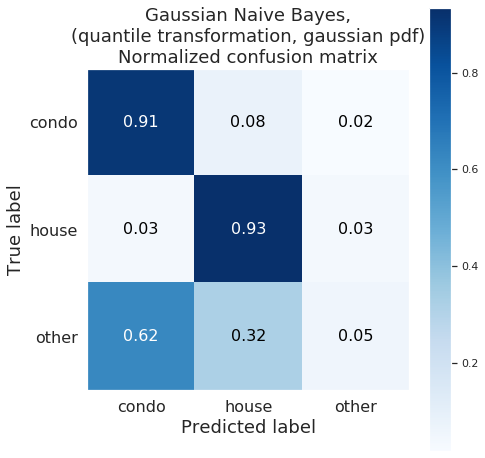

In [63]:
plot_confusion_matrix(y_test, nb.predict(X_test_qn), le.classes_, model_name, normalize=True, width=7)
plt.show()

### Tree-based models

#### Decision Tree

In [64]:
max_depth = 25
model_name = "Decision Tree\n('gini' criterion, max_depth={0})".format(max_depth)
model_code = 'tree{0}_raw'.format(max_depth)
tree = DecisionTreeClassifier(criterion='gini', random_state=random_state, max_depth=max_depth)
scores_df.loc[model_code] = \
    fit_model(tree, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)


Decision Tree
('gini' criterion, max_depth=25) fit, took 8.77 seconds (0.15 minutes)
accuracy: train=0.99, test=0.96, validation #1=0.93, validation #2=0.86


In [65]:
tree = DecisionTreeClassifier(criterion='gini', random_state=random_state, max_depth=max_depth)
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

0.9583421013662544

In [66]:
cr = classification_report(y_test, tree.predict(X_test), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Decision Tree
('gini' criterion, max_depth=25)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.991807,0.937332,0.954484,0.958342,0.961207,0.958417
recall,0.990235,0.946979,0.947206,0.958342,0.961473,0.958342
f1-score,0.991020,0.942131,0.950831,0.958342,0.961327,0.958366
support,66871.000000,86664.000000,103079.000000,0.958342,256614.000000,256614.000000


Decision Tree
('gini' criterion, max_depth=25)
Normalized confusion matrix
[[0.99 0.01 0.  ]
 [0.   0.95 0.05]
 [0.   0.05 0.95]]


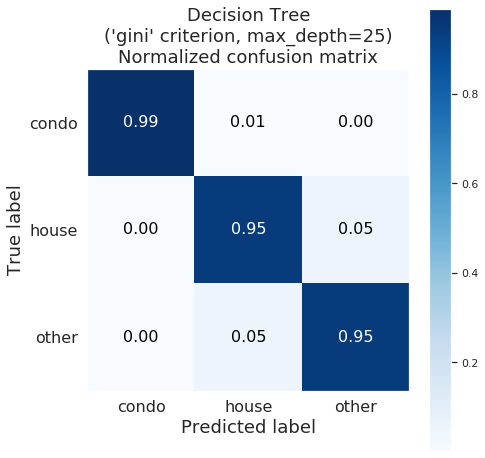

In [67]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, tree.predict(X_test), le.classes_, model_name, normalize=True, width=7)
plt.show()

In [68]:
dot_data = export_graphviz(tree, filled=True, rounded=True, class_names=le.classes_,
                           feature_names=feat_cols, out_file='../../results/{0}_tree{1}_visualization.dot'
                                                             .format(feat_set_name, max_depth))
# graph = graph_from_dot_data(dot_data)
# graph.set('dpi', '500')
# graph.write_png('../../results/plots/tree_teranet_census_tts_4c.png')

#### Random Forest

In [69]:
n_jobs = 12
n_estimators = 50
model_name = "Random Forest\n('gini' criterion, n_estimators={0})".format(n_estimators)
model_code = 'forest{0}_raw'.format(n_estimators)
forest = RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=n_jobs, n_estimators=n_estimators)
scores_df.loc[model_code] = \
    fit_model(forest, model_name, X_train, y_train, X_test, y_test, X_val1, y_val1, X_val2, y_val2,
              return_scores=True)


Random Forest
('gini' criterion, n_estimators=50) fit, took 21.15 seconds (0.35 minutes)
accuracy: train=1.00, test=0.97, validation #1=0.95, validation #2=0.88


In [70]:
forest = RandomForestClassifier(criterion='gini', random_state=random_state, n_jobs=n_jobs, n_estimators=n_estimators)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.9687546275729305

In [71]:
cr = classification_report(y_test, forest.predict(X_test), output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for Random Forest
('gini' criterion, n_estimators=50)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.996800,0.940099,0.975766,0.968755,0.970888,0.969202
recall,0.992179,0.973011,0.949980,0.968755,0.971723,0.968755
f1-score,0.994484,0.956272,0.962700,0.968755,0.971152,0.968812
support,66871.000000,86664.000000,103079.000000,0.968755,256614.000000,256614.000000


Random Forest
('gini' criterion, n_estimators=50)
Normalized confusion matrix
[[9.92e-01 6.07e-03 1.75e-03]
 [2.77e-04 9.73e-01 2.67e-02]
 [1.83e-03 4.82e-02 9.50e-01]]


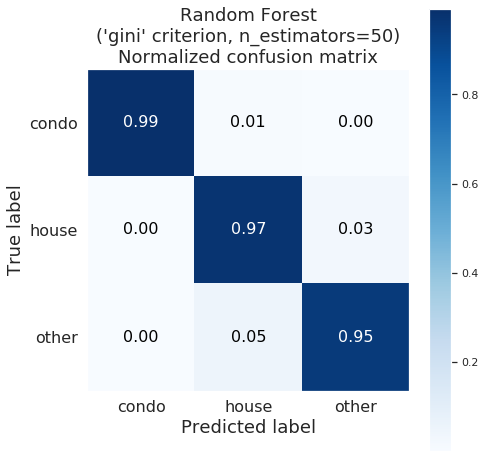

In [72]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, forest.predict(X_test), le.classes_, model_name, normalize=True, width=7)
plt.show()

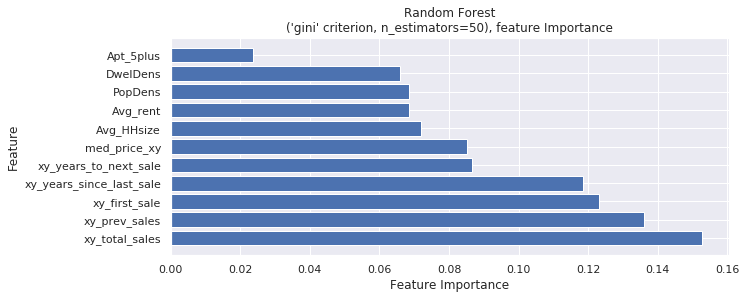

In [73]:
# plot feature importances from Random Forest
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

f, ax = plt.subplots(1, figsize=(10, 4))
ax.set_title('{0}, feature Importance'.format(model_name))
plt.barh(feat_cols, importances[indices], align='center')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Feature')
f.savefig('../../results/plots/{0}_{1}_feature_importance.png'.format(feat_set_name, model_code))

### Nearest neighbors

#### K-nearest neighbors

In [74]:
n_jobs = 12
p = 1
k = 4
model_name = "K-nearest neighbors (p={0}, k={1}, standardized)".format(p, k)
model_code = 'knn_std_p{0}_k{1}'.format(p, k)
knn = KNeighborsClassifier(metric='minkowski', p=p, n_neighbors=k, n_jobs=n_jobs)
scores_df.loc[model_code] = \
    fit_model(knn, model_name, X_train_std, y_train, X_test_std, y_test, X_val1_std, y_val1, X_val2_std, y_val2,
              return_scores=True)


K-nearest neighbors (p=1, k=4, standardized) fit, took 281.42 seconds (4.69 minutes)
accuracy: train=0.97, test=0.95, validation #1=0.92, validation #2=0.83


In [75]:
knn = KNeighborsClassifier(metric='minkowski', p=p, n_neighbors=k, n_jobs=n_jobs)
knn.fit(X_train_std, y_train)
knn.score(X_test_std, y_test)

0.95274614791087

In [76]:
y_pred = knn.predict(X_test_std)
cr = classification_report(y_test, y_pred, output_dict=True, target_names=le.classes_)
print("Classification report for {0}".format(model_name))
pd.DataFrame(cr)

Classification report for K-nearest neighbors (p=1, k=4, standardized)


,condo,house,other,accuracy,macro avg,weighted avg
precision,0.987881,0.910705,0.968066,0.952746,0.955550,0.953857
recall,0.988560,0.963110,0.920799,0.952746,0.957490,0.952746
f1-score,0.988220,0.936175,0.943841,0.952746,0.956079,0.952817
support,66871.000000,86664.000000,103079.000000,0.952746,256614.000000,256614.000000


K-nearest neighbors (p=1, k=4, standardized)
Normalized confusion matrix
[[0.99 0.01 0.  ]
 [0.   0.96 0.03]
 [0.01 0.07 0.92]]


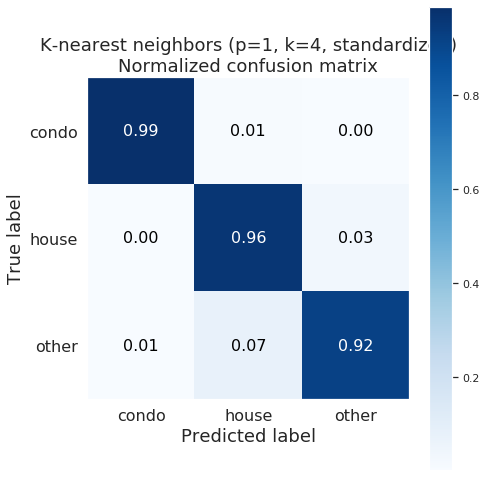

In [77]:
np.set_printoptions(precision=2)
plot_confusion_matrix(y_test, y_pred, le.classes_, model_name, normalize=True, width=7)
plt.show()

## Compare perfomance of models

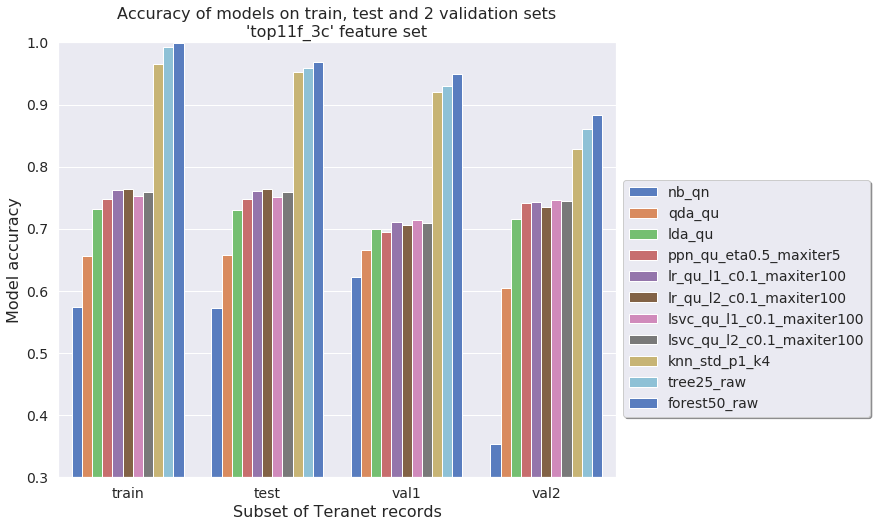

In [79]:
plot_order = [
    'nb_qn',
    'qda_qu',
    'lda_qu',
    'ppn_qu_eta0.5_maxiter5',
    'lr_qu_l1_c0.1_maxiter100',
    'lr_qu_l2_c0.1_maxiter100',
    'lsvc_qu_l1_c0.1_maxiter100',
    'lsvc_qu_l2_c0.1_maxiter100',
    'knn_std_p1_k4',
    'tree25_raw',
    'forest50_raw'
]
scores_tidy = scores_df.reset_index().rename(columns={'index': 'model'})\
                       .melt(id_vars='model', var_name='subset', value_name='score')\
                       .sort_values(['model', 'subset'])
scores_tidy = scores_tidy.set_index('model').loc[plot_order].reset_index()
f, ax = plt.subplots(1, figsize=(10, 8))
sns.barplot(x="subset", y="score", hue="model", order=['train', 'test', 'val1', 'val2'],
                                                       data=scores_tidy, palette="muted", ax=ax)
ax.set_ylabel("Model accuracy", fontsize=16)
ax.set_xlabel("Subset of Teranet records", fontsize=16)
ax.set_title("Accuracy of models on train, test and 2 validation sets\n'{0}' feature set".format(feat_set_name), 
             fontsize=16)
ax.grid(True)
ax.legend(bbox_to_anchor=(1.0, 0.7),
          ncol=1, fancybox=True, shadow=True, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_ylim(0.3, 1.0)
plt.grid(axis='x')
plt.savefig('../../results/plots/{0}_model_performance.png'.format(feat_set_name), bbox_inches='tight')